# DS4440 - Practical Neural Networks
## Image Classification using Convolution Neural Networks

___
**Instructor** : Prof. Steve Schmidt <br/>
**Teaching Assistants** : Vishwajeet Hogale (hogale.v@northeastern.edu) | Chaitanya Agarwal (agarwal.cha@northeastern.edu)

## Problem Statement
In this notebook, we'll learn about Convolutional Neural Networks (CNNs) using the Fashion MNIST dataset. CNNs are special neural networks designed to work with images by using convolutional layers that scan the image to find patterns.

### We will:
1. Build a CNN for binary classification (T-shirt vs. Trouser)
2. Build a CNN for multi-class classification (all 10 fashion items)

### What makes CNNs special?
- CNNs use **filters (kernels)** that slide over the image to detect patterns
- These filters can find edges, textures, and other important features
- They're much better at understanding images than regular neural networks

## 0. Setup and Load libraries

The below cell helps you download all the necessary libraries or packages required to run this notebook without running into any errors.

In [1]:
! pip install -r requirements.txt

## 1. Data Gathering

### **About the Dataset**

The Fashion MNIST dataset consists of **70,000 labeled grayscale images**, each with a resolution of **28x28 pixels and 10 distinct classes**. This structured dataset allows us to experiment with building and training models, tuning hyperparameters, and evaluating performance.


Each example in the dataset is assigned to one of the following labels:

0 T-shirt/top<br/>
1 Trouser<br/>
2 Pullover<br/>
3 Dress<br/>
4 Coat<br/>
5 Sandal<br/>
6 Shirt<br/>
7 Sneaker<br/>
8 Bag<br/>
9 Ankle boot
<br/>
<br/>

**Dataset Source**
<br/>
The Fashion MNIST Dataset is a very popular dataset, which is already present in the torch library. What we're going to do is that we will fetch this dataset from torch and download it in our current working directory.
<br/><br/>

**What is the below cell doing?**<br/>
The below cell downloads the Fashion MNIST images in the current working directory. Torch offers **60,000** images as training images and **10,000** images as testing images. 



In [2]:
from torchvision import datasets, transforms

# Convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors (values between 0 and 1)
    transforms.Normalize((0.5,), (0.5,))  # Center the data around 0 (-1 to 1)
])

# Load Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)


100%|██████████| 26421880/26421880 [00:10<00:00, 2432807.16it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 302299.29it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5500618.52it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3319335.43it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### In this notebook, we will pass the images through the neural network. But, there are a few extra steps that needs to be performed. 

#### Setting up Data Loaders
##### What are dataloaders ? 
Data Loaders help us organize and load our data into our model in small chunks, so the model can learn from the data one batch at a time. 

##### Why do we need them ? 
- **Efficient memory usage**: Load data in small batches instead of all at once.
- **Faster training**: Process data in batches to speed up learning.
- **Shuffling**: Randomize data order to improve model performance.

##### What do they do ? 
- They create several batches of batch_size * (image : label) pairs for the model to learn about patterns in images.

In [3]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Loads the training data in batches of 64 images at a time.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Loads the testing data in batches of 64 images at a time.

#### Visualize an image from a batch

In [4]:
fashion_mnist_classes = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def load_image_from_batch():
    # Get one batch of data from the train_loader
    for images, labels in train_loader:
        # Get the first image from the batch using indexing
        image = images[0]
        label = labels[0]
        break  # Exit the loop after getting the first batch

    # Convert the PIL image to a NumPy array
    image = image[0].numpy()  # Convert the 28x28 image to NumPy array (shape: (28, 28))

    # Display the image using matplotlib
    plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale image
    plt.title("Label: {}".format(fashion_mnist_classes[label.item()]))  # Show the label as the title
    plt.axis('off')  # Hide the axis
    plt.show()

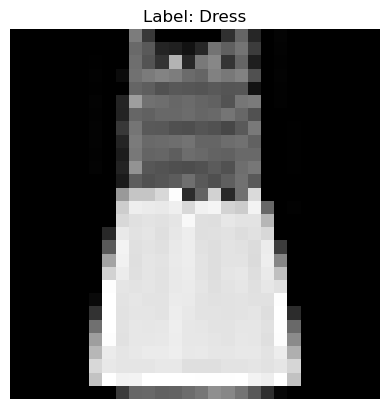

In [6]:
load_image_from_batch()

## 2. Data Wrangling

### Check the size of the training dataset

In [7]:

num_images_train = len(train_dataset)
num_images_test = len(train_dataset)
# Print the number of images in the dataset
print(f"The train dataset has {num_images_train} images")
print(f"The train dataset has {num_images_test} images")


The train dataset has 60000 images
The train dataset has 60000 images


## 3. Model Building

### **3.1 Binary Classification**

In this task, we're going to pick any two classes from the fashion MNIST dataset and show how to use Binary Cross Entropy Loss for the binary predictions using MLP.

In [8]:


lr = 0.0001 # learning rate
epochs = 10
batch_size = 64
num_classes = 2  # number of classes in FashionMNIST


print('Learning rate:', lr)
print('Batch size:', batch_size)
print('Number of epochs:', epochs)

Learning rate: 0.0001
Batch size: 64
Number of epochs: 10


In [9]:
import torch
def create_binary_dataset(dataset):
    # Keep only classes 0 and 1
    indices = [(label in [0, 1]) for _, label in dataset]
    return torch.utils.data.Subset(dataset, [i for i, x in enumerate(indices) if x])


In [10]:
binary_train_dataset = create_binary_dataset(train_dataset)
binary_test_dataset = create_binary_dataset(test_dataset)

In [11]:
binary_train_loader = DataLoader(binary_train_dataset, batch_size=batch_size, shuffle=True)
binary_test_loader = DataLoader(binary_test_dataset, batch_size=batch_size)

#### About CNNs
CNNs are a type of neural network specifically designed for processing grid-like data, such as images. They're inspired by the human visual cortex and have revolutionized computer vision tasks.

#### Key Components:
- Convolutional Layers (Conv2d): These layers are the core building blocks of CNNs. They use filters (or kernels) that slide across the input image, performing element-wise multiplication and summing the results. This process helps detect features like edges, textures, and more complex patterns as you go deeper into the network.

    For example, in the code:
    ```
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    ```
    This creates a convolutional layer that takes a grayscale image (1 channel) and applies 16 different 3x3 filters to it1.
- Activation Functions (ReLU): After each convolutional layer, an activation function is applied. ReLU (Rectified Linear Unit) is commonly used as it introduces non-linearity and helps the network learn complex patterns1.
- Pooling Layers: While not used in this simple example, pooling layers are often crucial in CNNs. They reduce the spatial dimensions of the data, helping to:
    - Decrease computational load
    - Control overfitting
    - Achieve spatial invariance
- Flattening:
After the convolutional layers, the 2D feature maps are flattened into a 1D vector. This prepares the data for the fully connected layers. FFN aren't programmed to understand images, so they need to be converted to 1D tensors. In the code, this is done with:
python

    ```
    x = x.view(-1, 32 * 28 * 28)
    ```

This reshapes the tensor, essentially "unrolling" the 2D feature maps into a long 1D vector1.
- Fully Connected Layers: These layers take the flattened features and learn to classify the images. They're similar to layers in traditional neural networks1.

In [12]:
import torch.nn as nn
class SimpleBinaryCNN(nn.Module):
    def __init__(self):
        super(SimpleBinaryCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1,    # Grayscale images have 1 channel
                              out_channels=16,    # Number of filters
                              kernel_size=3,      # 3x3 filter size
                              padding=1)          # Keep input and output size same
        self.relu = nn.ReLU()
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, 
                              out_channels=32, 
                              kernel_size=3,
                              padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 28 * 28, 128)  # 28x28 is the image size
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # First conv layer
        x = self.conv1(x)    # Apply convolution
        x = self.relu(x)     # Apply ReLU activation
        
        # Second conv layer
        x = self.conv2(x)    # Apply convolution
        x = self.relu(x)     # Apply ReLU activation
        
        # Flatten the image for fully connected layers
        x = x.view(-1, 32 * 28 * 28)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)  # For binary classification
        return x

In [13]:
def train_model(model, train_loader, criterion, optimizer, epochs=5, device='cpu'):
    model.train()  # Set model to training mode
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        for images, labels in train_loader:
            # Move data to device (CPU/GPU)
            images = images.to(device)
            labels = labels.to(device)
            
            # Clear previous gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Prepare labels based on the task (binary/multi-class)
            if isinstance(criterion, nn.BCELoss):
                labels = labels.float()
                outputs = outputs.squeeze()
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            running_loss += loss.item()
            
        # Print progress
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}')

In [14]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Binary Classification
print("Training Binary Classification Model (T-shirt vs Trouser)...")
binary_model = SimpleBinaryCNN().to(device)
binary_criterion = nn.BCELoss()
binary_optimizer = optim.Adam(binary_model.parameters(), lr=0.001)

train_model(binary_model, binary_train_loader, binary_criterion, binary_optimizer, epochs=5, device=device)


Training Binary Classification Model (T-shirt vs Trouser)...
Epoch [1/5] Loss: 0.0520
Epoch [2/5] Loss: 0.0155


After training, the models are evaluated on a separate test set. The confusion matrices provide a visual representation of the model's performance, showing where it's making correct predictions and where it's confused

#### What does squeeze and unsqueeze do ? 


In [ ]:
import torch

# Create a tensor with shape (1, 3, 1)
x = torch.tensor([[[1], [2], [3]]])
print("Original tensor shape:", x.shape)

# Use squeeze() to remove dimensions of size 1
y = x.squeeze()
print("After squeeze:", y.shape)

# Use unsqueeze() to add a dimension
z = y.unsqueeze(0)
print("After unsqueeze(0):", z.shape)

# Add dimension at a different position
w = y.unsqueeze(1)
print("After unsqueeze(1):", w.shape)

Original tensor shape: torch.Size([1, 3, 1])
After squeeze: torch.Size([3])
After unsqueeze(0): torch.Size([1, 3])
After unsqueeze(1): torch.Size([3, 1])


In [ ]:
def evaluate_model(model, test_loader, device='cpu', binary=True):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Don't compute gradients for evaluation
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            
            # Get predictions
            if binary:
                preds = (outputs.squeeze() > 0.5).cpu().numpy()
            else:
                _, preds = torch.max(outputs, 1)
                preds = preds.cpu().numpy()
            
            # Store predictions and labels
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Binary model
binary_preds, binary_labels = evaluate_model(binary_model, binary_test_loader, device=device, binary=True)
binary_accuracy = accuracy_score(binary_labels, binary_preds)
print(f"\nBinary Classification (T-shirt vs Trouser) Accuracy: {binary_accuracy:.4f}")




Binary Classification (T-shirt vs Trouser) Accuracy: 0.9945


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    plt.figure(figsize=(10, 8))
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Binary Classification Results:


<Figure size 1000x800 with 0 Axes>

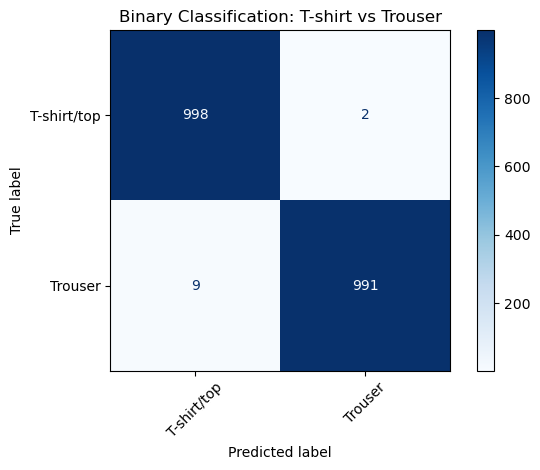

In [ ]:
print("Binary Classification Results:")
plot_confusion_matrix(binary_labels, binary_preds, 
                     classes=["T-shirt/top", "Trouser"],
                     title="Binary Classification: T-shirt vs Trouser")

### **3.2 Multi-Class Classification**
In this task, we're going to pick all the 10 classes from the fashion MNIST dataset and show how to use Cross Entropy Loss for the multi class predictions using MLP.

#### Hyperparameters

In [ ]:
lr = 0.0001 # learning rate
epochs = 10
batch_size = 64
num_classes = 10  # number of classes in FashionMNIST


print('Learning rate:', lr)
print('Batch size:', batch_size)
print('Number of epochs:', epochs)

Learning rate: 0.0001
Batch size: 64
Number of epochs: 10


In [ ]:
multi_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
multi_test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
multi_train_loader

In [ ]:
class SimpleMultiCNN(nn.Module):
    def __init__(self):
        super(SimpleMultiCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, 
                              out_channels=16, 
                              kernel_size=3,
                              padding=1)
        self.relu = nn.ReLU()
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16,
                              out_channels=32,
                              kernel_size=3,
                              padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for multi-class classification
        
    def forward(self, x):
        # First conv layer
        x = self.conv1(x)
        x = self.relu(x)
        
        # Second conv layer
        x = self.conv2(x)
        x = self.relu(x)
        
        # Flatten the image
        x = x.view(-1, 32 * 28 * 28) # can use .flatten() too!
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # No sigmoid needed for multi-class (CrossEntropyLoss includes softmax)


In [ ]:
print("\nTraining Multi-class Classification Model (All 10 classes)...")
multi_model = SimpleMultiCNN().to(device)
multi_criterion = nn.CrossEntropyLoss()
multi_optimizer = optim.Adam(multi_model.parameters(), lr=0.001)

train_model(multi_model, multi_train_loader, multi_criterion, multi_optimizer, epochs=5, device=device)



Training Multi-class Classification Model (All 10 classes)...
Epoch [1/5] Loss: 0.3929
Epoch [2/5] Loss: 0.2491
Epoch [3/5] Loss: 0.1880
Epoch [4/5] Loss: 0.1403
Epoch [5/5] Loss: 0.1013


In [ ]:
# Multi-class model
multi_preds, multi_labels = evaluate_model(multi_model, multi_test_loader, device=device, binary=False)
multi_accuracy = accuracy_score(multi_labels, multi_preds)
print(f"Multi-class Classification (All 10 classes) Accuracy: {multi_accuracy:.4f}")


Multi-class Classification (All 10 classes) Accuracy: 0.9129



Multi-class Classification Results:


<Figure size 1000x800 with 0 Axes>

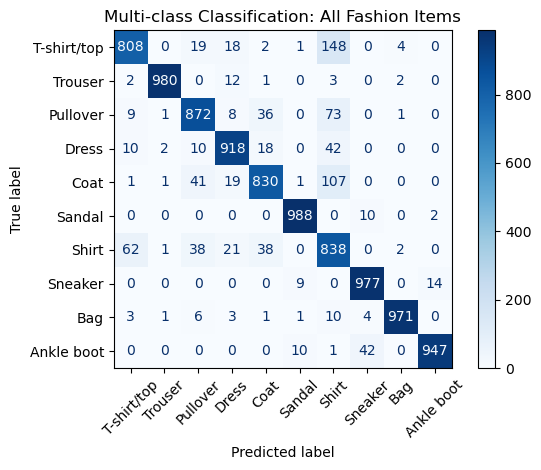

In [ ]:
print("\nMulti-class Classification Results:")
plot_confusion_matrix(multi_labels, multi_preds,
                     classes=list(fashion_mnist_classes.values()),
                     title="Multi-class Classification: All Fashion Items")

## 4. Other Visualizations

The cell below is complicated but it essentially just stores correct and wrong predictions by the model. And displays it.

In [ ]:
def evaluate_and_show_examples(model, test_loader, device='cuda'):
    """
    Evaluate model and show one correct and one incorrect prediction.
    """
    class_labels = {
        0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
        5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"
    }
    
    model.eval()
    correct_example = None
    incorrect_example = None
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Find one correct and one incorrect example
            for i in range(len(labels)):
                if correct_example is None and predicted[i] == labels[i]:
                    correct_example = (images[i].cpu(), labels[i].item(), predicted[i].item())
                if incorrect_example is None and predicted[i] != labels[i]:
                    incorrect_example = (images[i].cpu(), labels[i].item(), predicted[i].item())
                if correct_example and incorrect_example:
                    break
            if correct_example and incorrect_example:
                break
    
    # Plot the examples
    plt.figure(figsize=(10, 5))
    
    # Plot correct prediction
    plt.subplot(1, 2, 1)
    image, true_label, pred_label = correct_example
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Correct Prediction\nTrue: {class_labels[true_label]}')
    
    # Plot incorrect prediction
    plt.subplot(1, 2, 2)
    image, true_label, pred_label = incorrect_example
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Incorrect Prediction\nTrue: {class_labels[true_label]}\nPredicted: {class_labels[pred_label]}')
    
    plt.show()

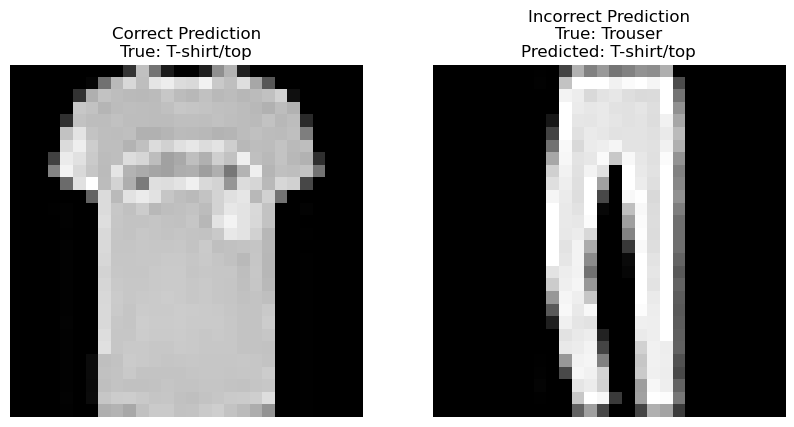

In [ ]:
evaluate_and_show_examples(binary_model, binary_test_loader, None)

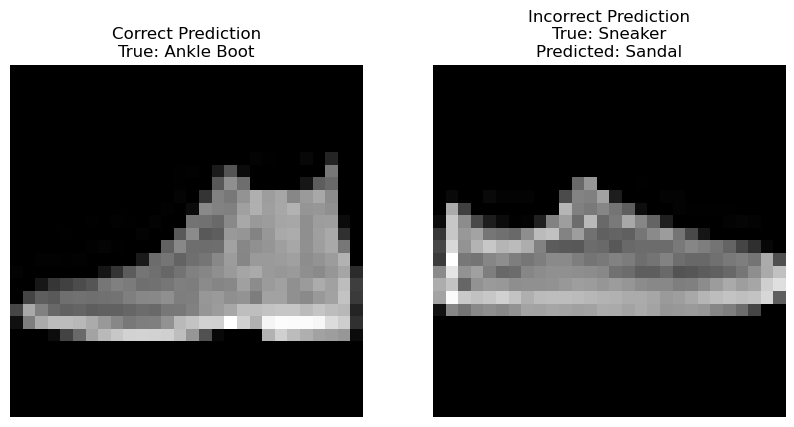

In [ ]:
evaluate_and_show_examples(multi_model, multi_test_loader, None)